<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.4f}'.format

Загрузка данных

In [3]:
df_toxic = pd.read_csv('/datasets/toxic_comments.csv')

Обзор данных

In [4]:
df_toxic.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [5]:
df_toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


* Присутствует столбец,  дублирующий индекс
* Сообщения на английском

Удаление столбца, дублирующего индекс

In [6]:
df_toxic = df_toxic.drop('Unnamed: 0',axis =1)

Распределение негативной окраски сообщений

<AxesSubplot:title={'center':'Баланс токсичности ответов'}, ylabel='toxic'>

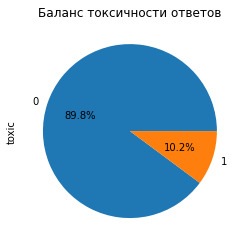

In [7]:
df_toxic['toxic'].value_counts().plot(kind = 'pie', title = 'Баланс токсичности ответов',autopct='%1.1f%%')

* Присутствует дисбаланс
* Сложно сделать вывод -   10 % токсичных ответов это много или мало, нет сравнения

Подготовка трейна

**Разделение выборки на обучающую и тестовую**

In [8]:
train,test = train_test_split(df_toxic,test_size = .25)

train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

# features_train = train.drop('toxic',axis =1)
target_train = train['toxic']

In [9]:
corpus_train = train['text'].values

**Обработка текста**

In [10]:
lemmatize = nltk.WordNetLemmatizer()

In [11]:
lemma_text_train = []
for i in corpus_train:
    #удаляем неалфавитные символы
    text = re.sub("[^a-zA-Z]"," ",i) 
    # токенизируем слова
    text = nltk.word_tokenize(text,language = "english")
    # лемматирзируем слова
    text = [lemmatize.lemmatize(word) for word in text]
    # соединяем слова
    text = " ".join(text)
    lemma_text_train.append(text)

In [12]:
corpus_train[0]

'season 5 issues\nNot sure why you removed my edits on the season 5 futurama issue, but I think it has merit. The total lack of season 5 info is confusing and not sure why the season 5 info is replaced by the movie information. You could have informed me at least on why you removed my discussion comment.'

In [13]:
lemma_text_train[0]

'season issue Not sure why you removed my edits on the season futurama issue but I think it ha merit The total lack of season info is confusing and not sure why the season info is replaced by the movie information You could have informed me at least on why you removed my discussion comment'

**Получение TF-IDF**

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)


tf_idf_train = count_tf_idf.fit_transform(lemma_text_train)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

Поиск модели

**LogisticRegression**

In [15]:
params = {
   'penalty':['l1', 'l2'],        
   'C':[1,4,6] 
}

grid_logreg = GridSearchCV(LogisticRegression(random_state=123,class_weight = 'balanced',solver='liblinear',max_iter = 150),
                           params,  scoring='f1',cv=2)

In [16]:
grid_logreg.fit(tf_idf_train, target_train)

GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight='balanced', max_iter=150,
                                          random_state=123,
                                          solver='liblinear'),
             param_grid={'C': [1, 4, 6], 'penalty': ['l1', 'l2']},
             scoring='f1')

**DecisionTreeClassifier**

In [17]:
params = { 
       'max_depth':[5,7] 
        }
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=123,class_weight ='balanced'), params, cv=2, scoring='f1')

In [18]:
grid_tree.fit(tf_idf_train, target_train)

GridSearchCV(cv=2,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'max_depth': [5, 7]}, scoring='f1')

In [19]:
pd.DataFrame({'F1_score' : [grid_logreg.best_score_,grid_tree.best_score_]},
             index = ['LogisticRegression','DecisionTreeClassifier'])

,F1_score
LogisticRegression,0.7577
DecisionTreeClassifier,0.5103


На основании метрики F1 отбираем лучшую модель

## Выводы

**Тестирование лучшей модели** 

Подготовка тестовой выборки

In [20]:
target_test = test['toxic']

In [23]:
corpus_test = test['text'].values

In [24]:
lemma_text_test = []
for i in corpus_test:
    #удаляем неалфавитные символы
    text = re.sub("[^a-zA-Z]"," ",i) 
    # токенизируем слова
    text = nltk.word_tokenize(text,language = "english")
    # лемматирзируем слова
    text = [lemmatize.lemmatize(word) for word in text]
    # соединяем слова
    text = " ".join(text)
    lemma_text_test.append(text)

Получение TF-IDF для теста

In [25]:
tf_idf_test = count_tf_idf.transform(lemma_text_test)

In [26]:
predictions_test = grid_logreg.best_estimator_.predict(tf_idf_test)
f1_best_model = f1_score(target_test, predictions_test)

In [27]:
print('Метрика F1 для лучшей модели:', f1_best_model)

Метрика F1 для лучшей модели: 0.763206672845227


**Проверка адекватности**

In [28]:
dummy= DummyClassifier(strategy = 'uniform')

dummy.fit(tf_idf_train,target_train) 
dummy_predictions = dummy.predict(tf_idf_test)
f1_dummy = f1_score(target_test,dummy_predictions)

print('Метрика F1 для константной модели:', f1_dummy)

Метрика F1 для константной модели: 0.17070600632244468


In [29]:
pd.DataFrame({'F1_score':[f1_best_model,f1_dummy]},
             index = ['LogisticRegression','Const_model'])

,F1_score
LogisticRegression,0.7632
Const_model,0.1707


Выводы:
* Проведена обработка текстовых сообщений
* Получена модель для предсказания наличия негативных эмоций в сообщениях с метрикой качества не ниже указанной  в ТЗ